# Random Forests with IMDB

### Introduction

In this lesson let's practice working with random forests on our imdb dataset.  Let's get started.

### Loading up our Data

We'll begin by loading our data.

In [27]:
import pandas as pd
url = "https://raw.githubusercontent.com/jigsawlabs-student/Random-Forests/master/imdb_movies.csv"
df = pd.read_csv(url)

In [28]:
df[:3]

,title,genre,budget,runtime,year,month,revenue
0,Avatar,Action,237000000,162.0,2009,12,2787965087
1,Pirates of the Caribbean: At World's End,Adventure,300000000,169.0,2007,5,961000000
2,Spectre,Action,245000000,148.0,2015,10,880674609


We'll select everything from `genre` through `month` as our features and revenue as our target.

In [29]:
X = df.loc[:, 'genre':'month']

In [30]:
y = df[['revenue']]

Use `any` to check that we do not have any missing values in our target values.

In [31]:
y.isna().any()

# False

revenue    False
dtype: bool

In [32]:
X[:2]
# 	genre	budget	runtime	year	month
# 0	Action	237000000	162.0	2009	12
# 1	Adventure	300000000	169.0	2007	5

,genre,budget,runtime,year,month
0,Action,237000000,162.0,2009,12
1,Adventure,300000000,169.0,2007,5


In [33]:
y[:2]

# 0    2787965087
# 1     961000000
# Name: revenue, dtype: int64

,revenue
0,2787965087
1,961000000


### Coercing our Data

Let's use a `LabelEncoder` to change our `genre` feature.  The feature also has `na`, so it is important to first change them into the string `na`.

> * Otherwise, we will see the following error -> 
> * TypeError: argument must be a string or number

Ok, go for it.

In [34]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

mapper = DataFrameMapper([
    (['genre'], [SimpleImputer(strategy = 'constant', fill_value = 'na'), LabelEncoder()])
], df_out = True)

In [36]:
genre_transformed = mapper.fit_transform(X)

/Users/jeff/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Next replace our `genre` column in X with this data.

In [37]:
X = X.assign(genre = genre_transformed)

In [38]:
X[:2]

# 	genre	budget	runtime	year	month
# 0	0	237000000	162.0	2009	12
# 1	1	300000000	169.0	2007	5

,genre,budget,runtime,year,month
0,0,237000000,162.0,2009,12
1,1,300000000,169.0,2007,5


Next let's see if there are any other `isna` values to handle in our features.

In [39]:
X.isna().any()

# genre      False
# budget     False
# runtime    False
# year       False
# month      False
# dtype: bool

genre      False
budget     False
runtime    False
year       False
month      False
dtype: bool

Ok, and one last look at our dtypes to ensure that everything is converted to a number.

In [40]:
X.dtypes

# genre        int64
# budget       int64
# runtime    float64
# year         int64
# month        int64
# dtype: object


genre        int64
budget       int64
runtime    float64
year         int64
month        int64
dtype: object

Ok, we are set to split our data, and train our random forest.

### Splitting our Data

Before we split our data into training, validation and test sets, we should order our data by the year and month of the movie release.  First order the X data by year and month.

In [41]:
X_sorted = X.sort_values(['year', 'month'])

In [42]:
X_sorted[:3]

# 	genre	budget	runtime	year	month
# 1108	2	2600000	88.0	1940	2
# 862	5	2000000	153.0	1962	6
# 1125	5	31115000	248.0	1963	6

,genre,budget,runtime,year,month
1108,2,2600000,88.0,1940,2
862,5,2000000,153.0,1962,6
1125,5,31115000,248.0,1963,6


Then we can use the indices of `X` to impose the same ordering on our series `y`.

In [43]:
y_sorted = y.loc[X_sorted.index]

In [19]:
y_sorted[:3]

# 	revenue
# 252	227817248
# 593	67112664
# 1118	51070807

,revenue
252,227817248
593,67112664
1118,51070807


Ok, now that we've ordered the data, let's split it into training, validation and test sets.

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sorted, y_sorted, test_size = .2, shuffle = False)

In [46]:
X_validate, X_test, y_validate, y_test = train_test_split(X_test, y_test, test_size = .5, shuffle = False)

In [47]:
X_train.shape, X_validate.shape, X_test.shape

# ((1600, 5), (200, 5), (200, 5))

((1600, 5), (200, 5), (200, 5))

Now let's train a random forest, and evaluate it on our validation set.

In [55]:
from sklearn.ensemble import RandomForestRegressor


model = RandomForestRegressor(n_estimators = 100, random_state = 1)

model.fit(X_train,y_train)

/Users/jeff/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

In [58]:
model.score(X_train, y_train)

# 0.9219605803655813

0.9219605803655813

In [57]:
model.score(X_validate, y_validate)

# 0.41940481253000517

0.41940481253000517

In [51]:
X_train[-1:]

,genre,budget,runtime,year,month
495,1,79000000,94.0,2012,1


### Changing the Year

One way we might be able to improve the model is by removing some of the early data.  Try training different models, beginning with data from year 2000 through 2014.

In [83]:
X_train_set = X[X['year'] < 2015]
y_train = y.loc[X_train_set.index]
X_validation_set = X[X['year'] == 2015] 
y_validation = y.loc[X_validation_set.index]


Add each model to the variable `models`.

In [84]:
years = list(range(2000, 2014))

In [87]:
models = []
for year in years:
    X_selected = X_train_set[X_train_set['year'] > year]
    y_selected = y_train.loc[X_selected.index]
    model = RandomForestRegressor(n_estimators = 100).fit(X_selected, y_selected['revenue'])
    models.append(model)

In [89]:
year_scores = [model.score(X_validation_set, y_validation) for model in models]
years_df = pd.DataFrame({'years': range(2000, 2014), 'scores': year_scores})

In [90]:
years_df

,years,scores
0,2000,0.462312
1,2001,0.484643
2,2002,0.478579
3,2003,0.484120
4,2004,0.497659
5,2005,0.482426
6,2006,0.508346
7,2007,0.488352
8,2008,0.468401
9,2009,0.470982


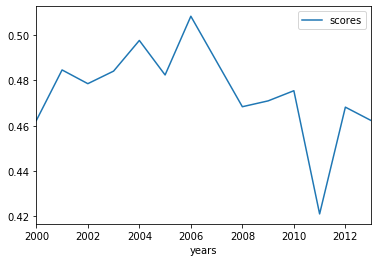

In [91]:
years_df.plot(x = 'years', y = 'scores')

It looks like our model peaks around 2006.

### Hyperparameter tuning

So let's train on data 2006 and later, and reserve data from 2015 for our validation set, and data from 2016 for our test set.

The validation set is already taken care of.

In [92]:
X_validation_set = X[X['year'] == 2015] 
y_validation = y.loc[X_validation_set.index]

In [95]:
X_validation_set.year.unique()

array([2015])

Select the training and test sets as specified above.

In [96]:
X_post_2006 = X_train[X_train['year'] > 2005]
y_post_2006 = y.loc[X_post_2006.index]

In [97]:
X_post_2006.shape, y_post_2006.shape
# ((571, 5), (571, 1))

((571, 5), (571, 1))

Ok, now train 20 different RandomForestRegressors setting min_samples_leaf from 5 to 100, incrementing by 5, for a total of 20 models.  Each model should be fit with 20 estimators.

In [107]:
depth_models = [RandomForestRegressor(min_samples_leaf = i,  n_estimators=20).fit(X_post_2006, y_post_2006.revenue) for i in range(5, 105, 5)]

In [108]:
depth_scores = [model.score(X_validate, y_validate) for model in depth_models]

In [109]:
df = pd.DataFrame({'levels': range(5, 105, 5), 'scores': depth_scores})

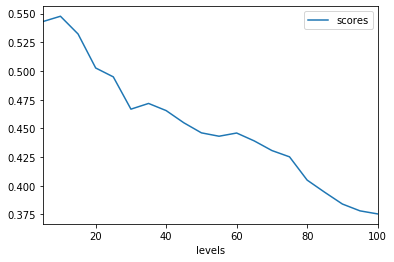

In [110]:
df.plot(x = 'levels', y = 'scores')

In [111]:
df[:9]

,levels,scores
0,5,0.543086
1,10,0.547746
2,15,0.532268
3,20,0.502639
4,25,0.494886
5,30,0.466745
6,35,0.471727
7,40,0.465484
8,45,0.454884


So it looks like we have hyperparameters that peak at `min_samples_leaf` of 10.  Finally, select data from 2006 to 2015 as the training and data, and evaluate on the selected test data.

In [112]:
comb_X = pd.concat([X_post_2006, X_validate])
comb_y = pd.concat([y_post_2006, y_validate])

In [114]:
model = RandomForestRegressor(min_samples_leaf = 10, n_estimators = 300)
model.fit(comb_X, comb_y.revenue) 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [115]:
model.score(X_validate, y_validate)

0.6371305725225579

In [116]:
model.score(X_test, y_test)
# 0.562667297695517

0.562667297695517

### Summary

In this lesson, we worked through training a RandomForestRegressor.  We did so by coercing our data using the DataFrameMapper along with the LabelEncoder.  We also saw that we can treat the earliest year of our training data as a hyperparameter, and by limiting older data we can improve the accuracy of our model.  Then we moved onto working with the `min_samples_leaf` hyperparameter, which further improved our score from .50 to .56.